In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from matplotlib import pyplot as plt
import torch 
import umap 

import sys 
sys.path.append('../../')
from src.models.NN import NN 

/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [253]:
adata = sc.datasets.pbmc3k()
adata

100%|██████████| 5.58M/5.58M [00:01<00:00, 3.57MB/s]
/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [254]:
adata.X.shape

(2700, 32738)

In [255]:
def compute_knn_graph(data, k):
    """
    Compute the k-nearest neighbors graph for a given RNA seq data array.

    Parameters:
    data (numpy.ndarray): The RNA seq data, shape (N_cells, N_genes).
    k (int): The number of nearest neighbors to find.

    Returns:
    coo_graph (scipy.sparse.coo_matrix): The k-nearest neighbors graph in COO format.
    distances (numpy.ndarray): The distances corresponding to each edge in the graph.
    """
    # Use sklearn's NearestNeighbors to find k nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(data)
    distances, indices = nbrs.kneighbors(data)

    # Remove self-edges (the first neighbor of each point is itself)
    distances = distances[:, 1:]
    indices = indices[:, 1:]

    # Prepare rows and columns for COO format
    rows = np.repeat(np.arange(data.shape[0]), k)
    cols = indices.reshape(-1)

    edge_index = np.stack((rows, cols))

    # Flatten the distances array
    distances = distances.reshape(-1)
    edge_attr = distances

    transition_vectors = data[cols] - data[rows]

    return edge_index, edge_attr, transition_vectors

In [257]:
#reducer = umap.UMAP(n_components=64)
#reducer.fit(adata.X)
#ux = reducer.transform(adata.X)

edge_index, edge_attr, transition_vectors = compute_knn_graph(adata.X, k=5)


In [258]:
G = nx.DiGraph([(x,y) for x,y in edge_index.T])
len(G)

2700

In [259]:
len(G.edges())

13500

In [179]:
pos = nx.spring_layout(G)

KeyboardInterrupt: 

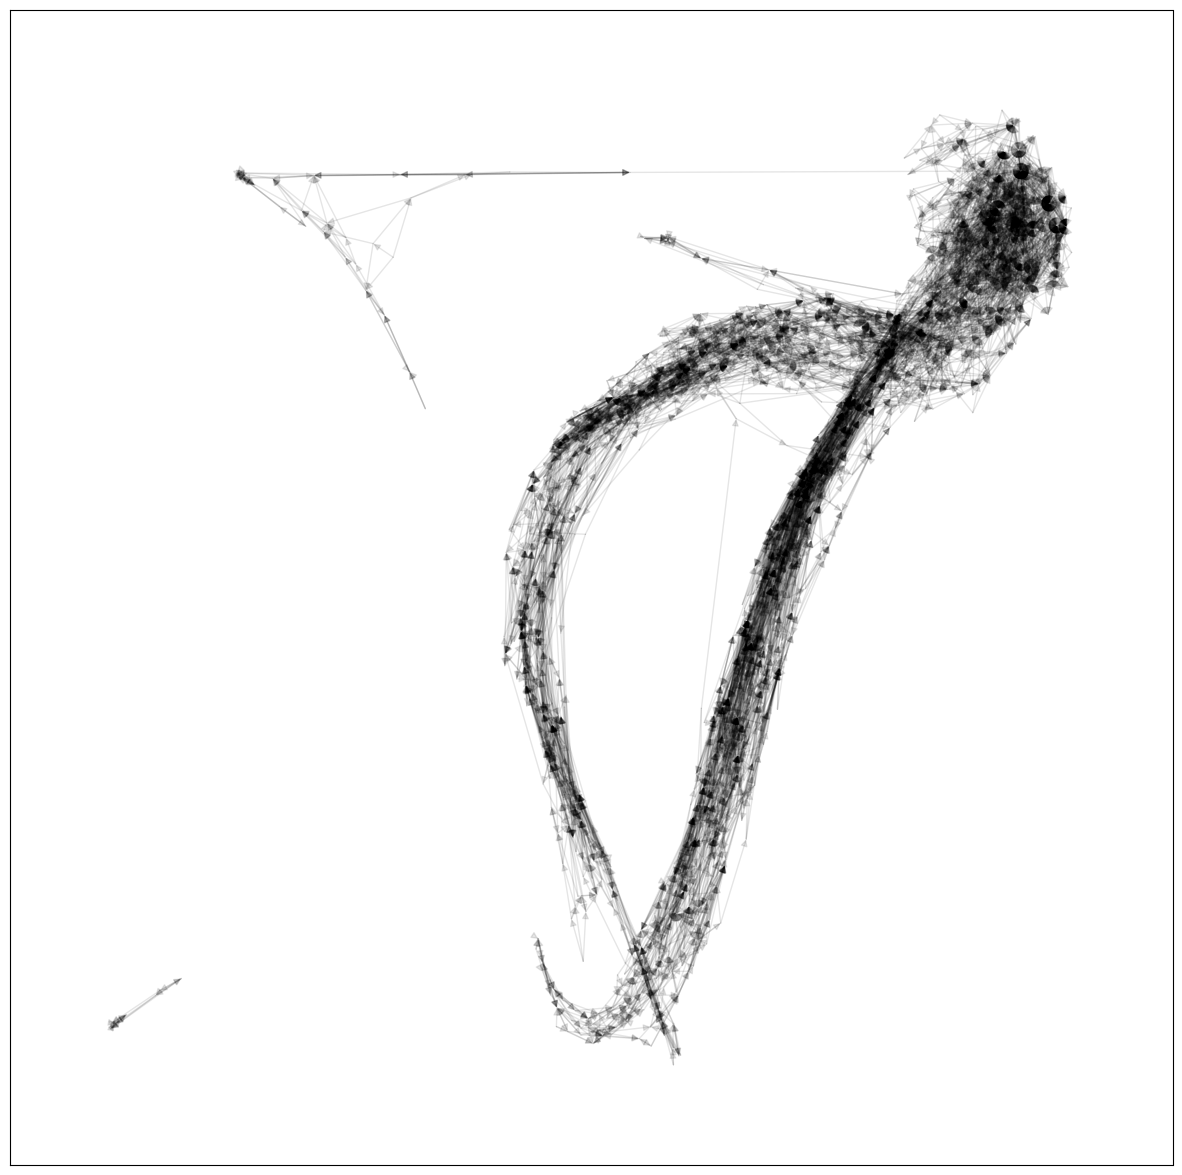

In [ ]:
plt.figure(figsize=(15,15))
nx.draw_networkx_edges(G, pos=pos, node_size=0, alpha=0.1)
plt.show()

In [191]:
transition_vectors.shape

(68250, 3451)

In [260]:
model = NN(adata.X.shape[1], hidden_channels=100, out_channels=adata.X.shape[1], layers=2, dropout=0.1, norm=torch.nn.BatchNorm1d).cuda()

In [261]:
crit = torch.nn.CosineEmbeddingLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [265]:
model = model.train()
X = torch.tensor(adata.X.getnnz(), dtype=torch.float).cuda()
T = torch.tensor(transition_vectors.getnnz(), dtype=torch.float).cuda()
edge_index = torch.tensor(edge_index, dtype=torch.long).cuda()

for epoch in range(1000): 
    optim.zero_grad()
    vhat = model(X)
    vhat_edges = vhat[edge_index[0, :]]
    pij = (torch.cosine_similarity(vhat_edges, T) + 1)/2
    wij = torch.bernoulli(pij)
    #wij = ((torch.cosine_similarity(vhat_edges, T) > 0.)*1.).detach()
    loss = crit(vhat_edges, T, wij)
    loss.backward() 
    optim.step() 

    print(f'epoch {epoch} loss: {loss:.4f}', end='\r')

RuntimeError: both arguments to matmul need to be at least 1D, but they are 0D and 2D

In [245]:
model.eval() 
vhat = model(X)

In [246]:
reducer = umap.UMAP().fit(adata.X)

KeyboardInterrupt: 

In [229]:
ux = reducer.transform(adata.X)
ux2 = reducer.transform(adata.X - vhat.detach().cpu().numpy()) # change 
uv = ux2-ux
ux.shape

(2730, 2)

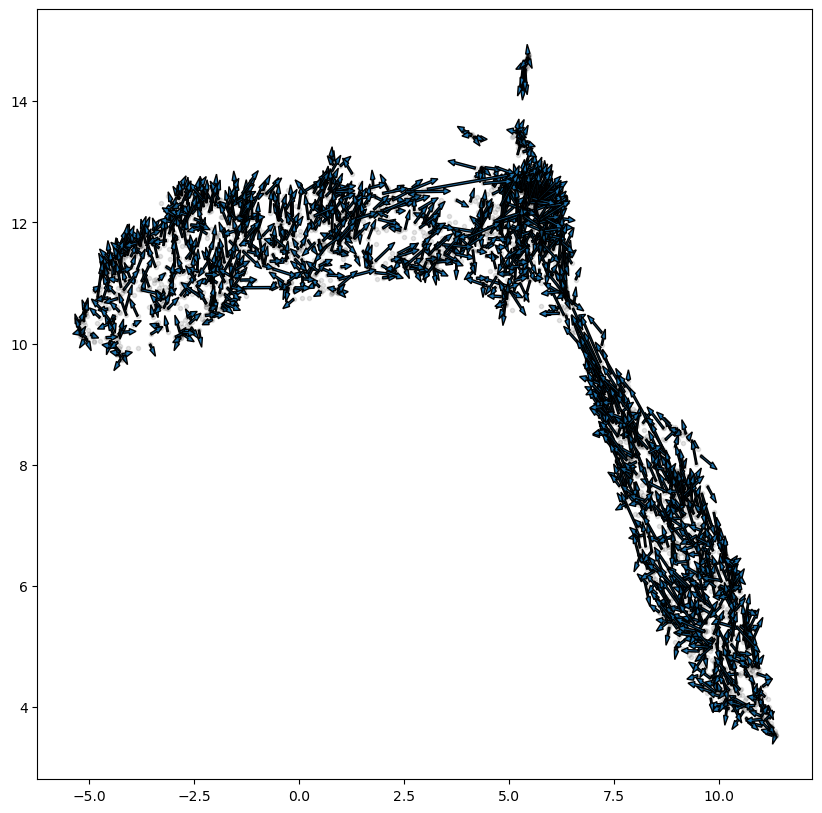

In [231]:
plt.figure(figsize=(10,10))
plt.plot(ux[:,0], ux[:,1], 'k.', alpha=0.1)

idxs = torch.randperm(ux.shape[0])[:1500]
for x,y, dx,dy in zip(ux[idxs,0], ux[idxs,1], uv[idxs,0], uv[idxs,1]): 
    plt.arrow(x,y,dx,dy, alpha=1., width=0.035)
plt.show()

In [75]:
vhat_edges.size()

torch.Size([8190, 3451])

In [76]:
T.size()

torch.Size([8190, 3451])

In [73]:
wij

tensor([1., 1., 1.,  ..., 1., 1., 1.], grad_fn=<SubBackward0>)

In [81]:
vhat

tensor([[ 2.6865e-01,  6.2398e-01,  4.7781e+00,  ...,  9.6461e-01,
          6.8990e+00,  3.9084e-01],
        [ 2.6143e-01,  1.3017e-01,  1.1387e+00,  ...,  3.3461e-01,
          1.1987e+00,  9.4622e-03],
        [ 1.8960e-02, -1.3830e+00, -3.9955e+00,  ..., -2.1351e+00,
         -8.7058e+00,  4.2457e-01],
        ...,
        [ 2.5886e-01,  5.8052e-01,  4.6323e+00,  ...,  9.4640e-01,
          6.6928e+00,  3.4817e-01],
        [ 2.0298e-01, -2.9299e-01, -2.2492e-01,  ..., -2.7101e-02,
         -1.5113e+00, -2.2049e-02],
        [ 2.7492e-01, -2.0562e+00, -5.6122e+00,  ..., -3.3152e+00,
         -1.3397e+01,  1.0462e+00]], grad_fn=<AddmmBackward0>)

In [56]:
pij

tensor([0.4871, 0.4895, 0.4925,  ..., 0.5182, 0.5097, 0.5141],
       grad_fn=<DivBackward0>)

In [ ]:
cosineEmbeddingLoss(dedt )